## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook. 

In [1]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#Model
from sklearn.ensemble import RandomForestRegressor



sns.set()

In [3]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [4]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y.flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [5]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [2]:
df = pd.read_csv("../../Datasets/Datos_antes_pandemia/data_antes_vol.csv")
df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

Fecha  VolFuturos
0    2010-01-01    0.000000
1    2010-01-02    4.256365
2    2010-01-03    0.794545
3    2010-01-04    0.787899
4    2010-01-05    0.601027
...         ...         ...
3648 2019-12-27    4.003614
3649 2019-12-28    2.090121
3650 2019-12-29    0.539108
3651 2019-12-30    1.815513
3652 2019-12-31    1.871355

[3653 rows x 2 columns]

---

## Desarrollo del modelo RF

In [7]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [8]:
df_stats=df

In [9]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [50]:
def Model(df_data,df_label,lag,estimators):
    
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns="VolFuturos",inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    print(df_test_y_normalize.shape)
    print(df_test.shape)


    #make model
    model=RandomForestRegressor(n_estimators=estimators)
    #fit the model with the train data
    history=model.fit(df_train,df_train_y_normalize)
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeRandomForest":["train"]*len(trainPredict.flatten()),"RandomForest" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeRandomForest":["test"]*len(testPredict.flatten()),"RandomForest":testPredict.flatten()}]
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados

(1093, 1)
(1093, 3)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.21645090061205932
MAE is : 0.33185571333253894
RMSE is : 0.46524284047372433
MAPE is : 16.346425854653273
Evaluation metric results:
MSE is : 1.0605412747787284
MAE is : 0.7838619685026537
RMSE is : 1.0298258468200963
MAPE is : 42.74289345006546
(1093, 1)
(1093, 3)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.20544846123226213
MAE is : 0.32580472045882825
RMSE is : 0.45326422893524493
MAPE is : 16.06634300378271
Evaluation metric results:
MSE is : 1.0489967783868674
MAE is : 0.7793979896137989
RMSE is : 1.0242054375889964
MAPE is : 42.45974206375371
(1093, 1)
(1093, 3)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.1985695001484057
MAE is : 0.3227609483223042
RMSE is : 0.44561137793867617
MAPE is : 15.93199171907726
Evaluation metric results:
MSE is : 1.0500954807256262
MAE is : 0.7790563746859833
RMSE is : 1.0247416653604098
MAPE is : 42.5076911791672
(1093, 1)
(1093, 3)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.19956736392045152
MAE is : 0.3227300546641452
RMSE is : 0.4467296317913683
MAPE is : 15.921368866888
Evaluation metric results:
MSE is : 1.0419354303082016
MAE is : 0.7778963753917115
RMSE is : 1.0207523844244506
MAPE is : 42.507827894459616
(1093, 1)
(1093, 3)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.19944998999135324
MAE is : 0.32364760718799174
RMSE is : 0.4465982422618267
MAPE is : 16.000250836672233
Evaluation metric results:
MSE is : 1.0414602608244856
MAE is : 0.77955065546795
RMSE is : 1.0205196033513935
MAPE is : 42.64399630210705
(1091, 1)
(1091, 5)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.20572665249551303
MAE is : 0.32719380706954343
RMSE is : 0.45357100050103843
MAPE is : 16.20978474163958
Evaluation metric results:
MSE is : 1.0508366025879514
MAE is : 0.7813017381322112
RMSE is : 1.0251032155778028
MAPE is : 43.245355329344385
(1091, 1)
(1091, 5)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.19653483166700164
MAE is : 0.3231620379847471
RMSE is : 0.44332249172244986
MAPE is : 16.01042930162532
Evaluation metric results:
MSE is : 1.0135397406374846
MAE is : 0.7741662130722277
RMSE is : 1.0067471085816362
MAPE is : 42.96027117102509
(1091, 1)
(1091, 5)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.19311658541923143
MAE is : 0.3204509350693153
RMSE is : 0.4394503219013856
MAPE is : 15.941379458379215
Evaluation metric results:
MSE is : 1.0151029614804057
MAE is : 0.7674416401341402
RMSE is : 1.0075231816094385
MAPE is : 42.674083088363076
(1091, 1)
(1091, 5)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.1958137220199489
MAE is : 0.3226707609524105
RMSE is : 0.44250844287984936
MAPE is : 16.046338537471687
Evaluation metric results:
MSE is : 1.0085947470958934
MAE is : 0.7680462313831725
RMSE is : 1.004288179307062
MAPE is : 42.684880261591985
(1091, 1)
(1091, 5)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.19302611378890677
MAE is : 0.3217955195359002
RMSE is : 0.43934737257539935
MAPE is : 16.048807126671303
Evaluation metric results:
MSE is : 1.0106355968008753
MAE is : 0.7685980595495236
RMSE is : 1.0053037336053594
MAPE is : 42.79255288182976
(1089, 1)
(1089, 7)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)


<ipython-input-4-f7487097fa4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[15,8])


Evaluation metric results:
MSE is : 0.20938418316736784
MAE is : 0.32720807110465727
RMSE is : 0.4575851649336633
MAPE is : 16.22474541825788
Evaluation metric results:
MSE is : 1.0236378239395632
MAE is : 0.762757206169852
RMSE is : 1.0117498821050404
MAPE is : 42.320665448682895
(1089, 1)
(1089, 7)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.20275280604856907
MAE is : 0.32498692076378133
RMSE is : 0.4502808079949323
MAPE is : 16.179806513501514
Evaluation metric results:
MSE is : 1.0087142213940363
MAE is : 0.7632458911570197
RMSE is : 1.004347659624911
MAPE is : 42.27965594516031
(1089, 1)
(1089, 7)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.1916340404617105
MAE is : 0.3212636573943506
RMSE is : 0.4377602545477496
MAPE is : 16.105891801888887
Evaluation metric results:
MSE is : 0.9938728756813566
MAE is : 0.7573393381929497
RMSE is : 0.9969317307024371
MAPE is : 42.198229320262506
(1089, 1)
(1089, 7)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.19347744401265646
MAE is : 0.32163567490768485
RMSE is : 0.4398607097851051
MAPE is : 15.996723081833528
Evaluation metric results:
MSE is : 1.0050837185587769
MAE is : 0.7649226458711157
RMSE is : 1.0025386369406302
MAPE is : 42.52858538935298
(1089, 1)
(1089, 7)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.19337187656312904
MAE is : 0.32161050345224507
RMSE is : 0.43974069241216357
MAPE is : 16.009938514082
Evaluation metric results:
MSE is : 0.9965752564297748
MAE is : 0.7574499224399364
RMSE is : 0.9982861595904127
MAPE is : 42.106833396605076
(1088, 1)
(1088, 8)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.21257293591363677
MAE is : 0.3290836955857463
RMSE is : 0.46105632618329484
MAPE is : 16.3663831505672
Evaluation metric results:
MSE is : 1.0198991420402943
MAE is : 0.7651714965094529
RMSE is : 1.009900560471324
MAPE is : 42.126727506553614
(1088, 1)
(1088, 8)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.1975750230429204
MAE is : 0.3242242715752608
RMSE is : 0.444494120369348
MAPE is : 16.23550888404298
Evaluation metric results:
MSE is : 1.0116017246898767
MAE is : 0.7591562152196577
RMSE is : 1.0057841342404825
MAPE is : 41.994537841171834
(1088, 1)
(1088, 8)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.19191378883753704
MAE is : 0.3203806955314235
RMSE is : 0.4380796603787227
MAPE is : 16.08202127879556
Evaluation metric results:
MSE is : 0.9954539744731117
MAE is : 0.7549246553077684
RMSE is : 0.9977243980544486
MAPE is : 41.80693537951565
(1088, 1)
(1088, 8)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.19058768087639924
MAE is : 0.3218949546953539
RMSE is : 0.4365634900863782
MAPE is : 16.19385830660972
Evaluation metric results:
MSE is : 0.9899993946331458
MAE is : 0.7517870203721886
RMSE is : 0.9949871328982831
MAPE is : 41.58864426588925
(1088, 1)
(1088, 8)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.19105498999256598
MAE is : 0.3206735802588682
RMSE is : 0.4370983756462222
MAPE is : 16.084824582288896
Evaluation metric results:
MSE is : 0.9875432106157734
MAE is : 0.7508859523711768
RMSE is : 0.9937520871000842
MAPE is : 41.60002025916602
(1086, 1)
(1086, 10)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.21117990728250832
MAE is : 0.3322902052930195
RMSE is : 0.4595431506208186
MAPE is : 16.614603846346903
Evaluation metric results:
MSE is : 1.0176902702883972
MAE is : 0.7659060254007063
RMSE is : 1.0088063591633418
MAPE is : 42.47205818165356
(1086, 1)
(1086, 10)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.19533015671033793
MAE is : 0.3214364645727593
RMSE is : 0.44196171407751816
MAPE is : 16.16045504456936
Evaluation metric results:
MSE is : 0.9827132000627409
MAE is : 0.7478529065087473
RMSE is : 0.9913189194516268
MAPE is : 41.386181713867465
(1086, 1)
(1086, 10)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.19494449590942636
MAE is : 0.32276876693356604
RMSE is : 0.44152519283663344
MAPE is : 16.157254373758985
Evaluation metric results:
MSE is : 0.9871579895560674
MAE is : 0.7496784562143565
RMSE is : 0.993558246685149
MAPE is : 41.507747377704604
(1086, 1)
(1086, 10)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.19217755445375925
MAE is : 0.3219637100872097
RMSE is : 0.43838060455927935
MAPE is : 16.158294576187675
Evaluation metric results:
MSE is : 0.9863283966641224
MAE is : 0.7472085824185777
RMSE is : 0.9931406731496412
MAPE is : 41.50136789493667
(1086, 1)
(1086, 10)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.19115032364740395
MAE is : 0.32046315887936444
RMSE is : 0.43720741490441806
MAPE is : 16.092195125624148
Evaluation metric results:
MSE is : 0.9848084149637765
MAE is : 0.7479469190172128
RMSE is : 0.9923751382233316
MAPE is : 41.53390077045872
(1081, 1)
(1081, 15)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.20339745313375027
MAE is : 0.32537900025322314
RMSE is : 0.4509960677586339
MAPE is : 16.32769417968913
Evaluation metric results:
MSE is : 0.9653929176332683
MAE is : 0.7391767083889779
RMSE is : 0.9825441046758503
MAPE is : 40.386476018087066
(1081, 1)
(1081, 15)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.1957242140666414
MAE is : 0.3223305623940454
RMSE is : 0.4424072943189809
MAPE is : 16.184647988763352
Evaluation metric results:
MSE is : 0.9596538392581383
MAE is : 0.7358946203301249
RMSE is : 0.9796192317722934
MAPE is : 40.20985709680121
(1081, 1)
(1081, 15)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.19297769128390588
MAE is : 0.31941581829271615
RMSE is : 0.4392922618074508
MAPE is : 16.009479600979382
Evaluation metric results:
MSE is : 0.945369444748011
MAE is : 0.7318550335242269
RMSE is : 0.9723011080668431
MAPE is : 40.04014080282312
(1081, 1)
(1081, 15)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.19056951421067767
MAE is : 0.31851480628689577
RMSE is : 0.43654268314871303
MAPE is : 15.943365091165715
Evaluation metric results:
MSE is : 0.9438729043492277
MAE is : 0.7322037716240308
RMSE is : 0.971531216353457
MAPE is : 39.941158682053235
(1081, 1)
(1081, 15)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.18938200933428534
MAE is : 0.3180288092568442
RMSE is : 0.43518043307837884
MAPE is : 15.954806280275372
Evaluation metric results:
MSE is : 0.9439642288468479
MAE is : 0.730571352321585
RMSE is : 0.9715782155065272
MAPE is : 39.97927934356868


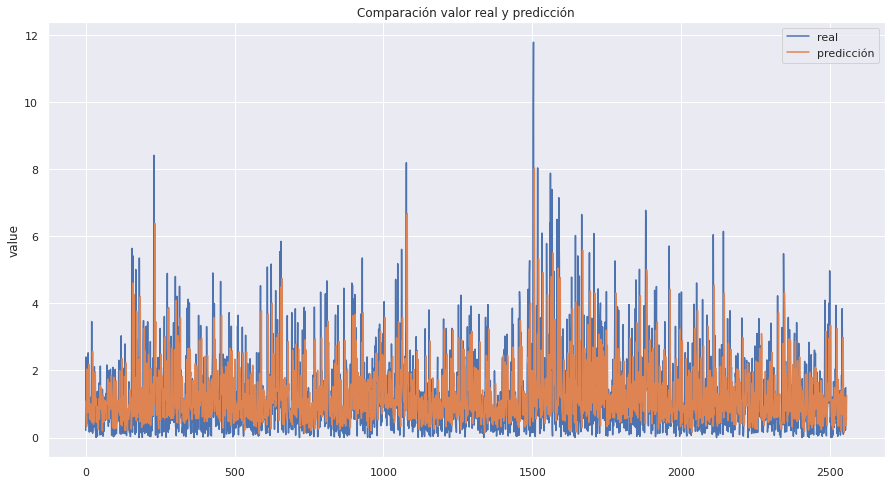

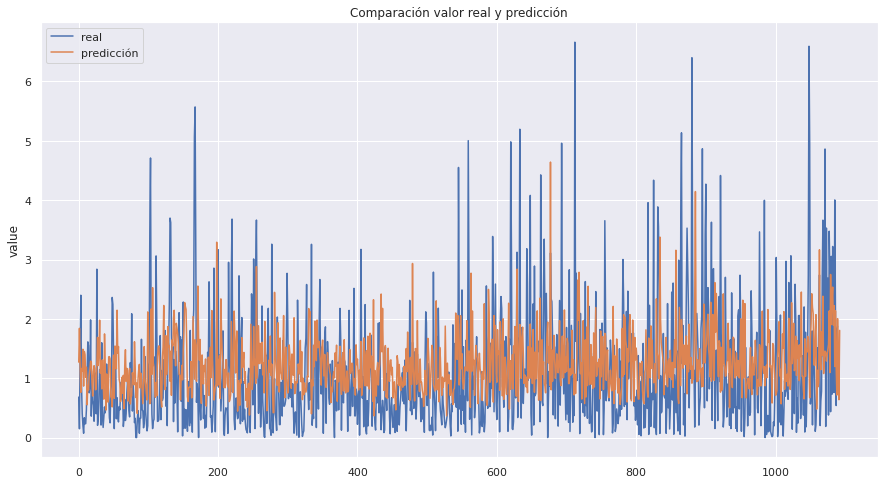

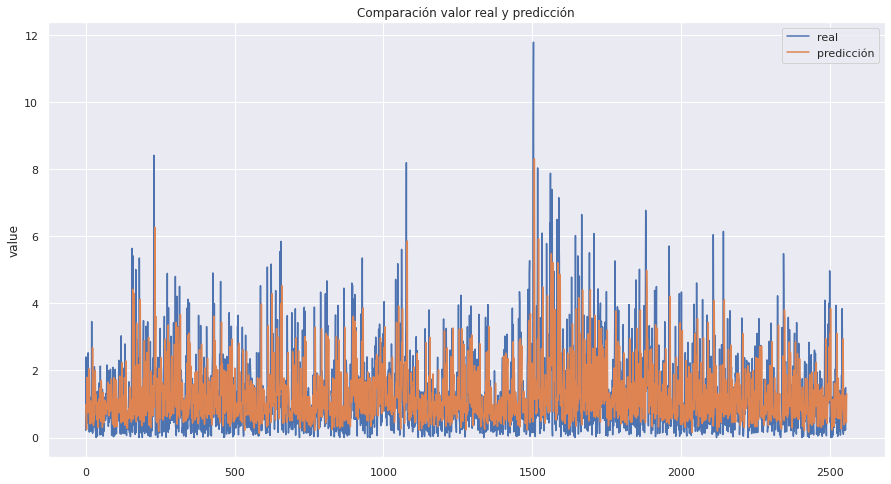

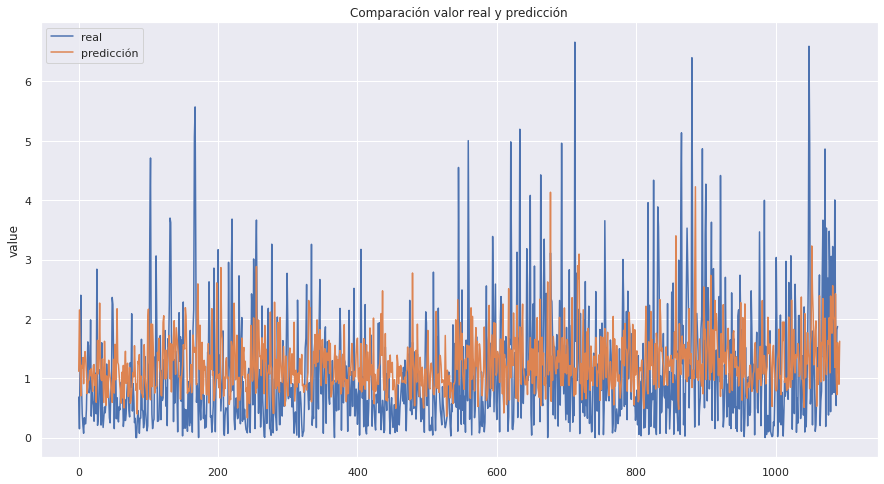

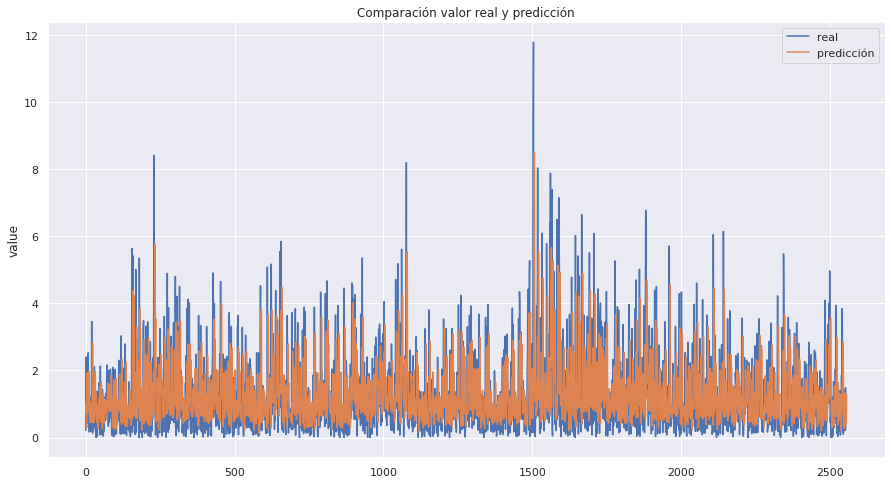

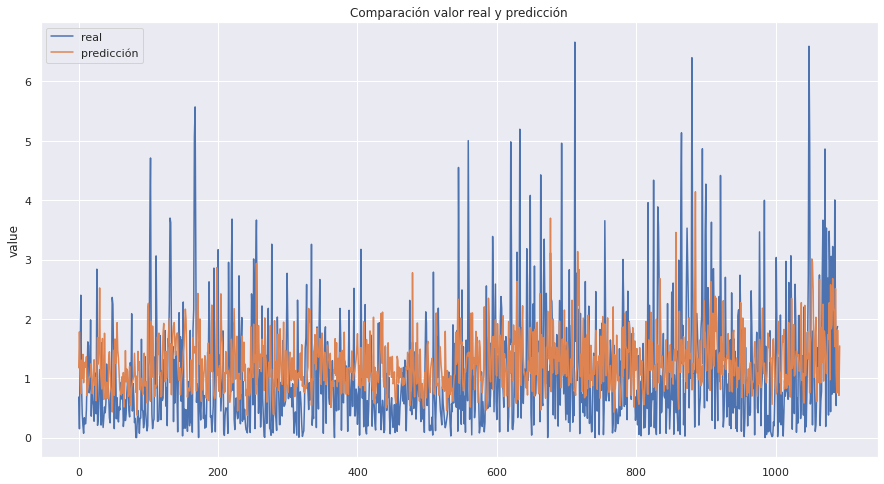

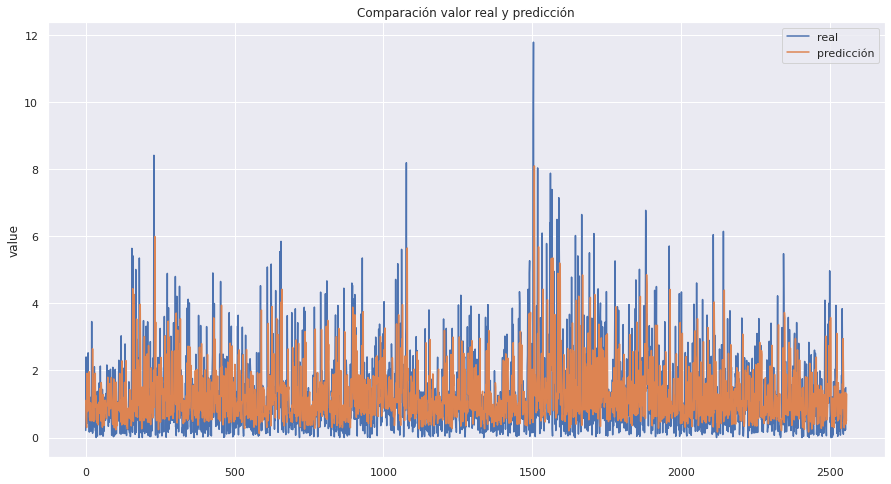

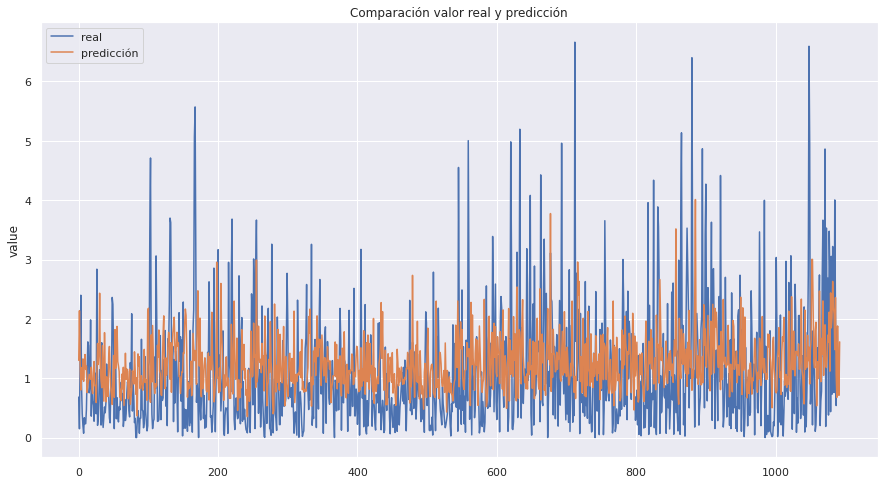

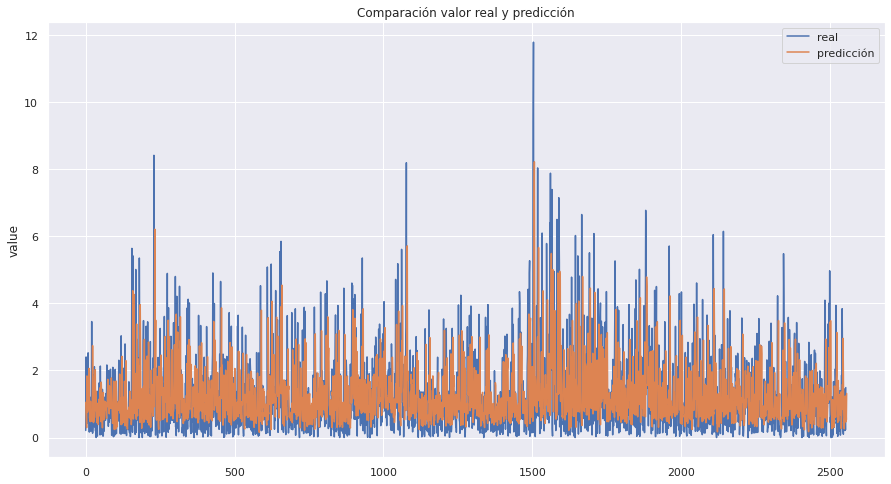

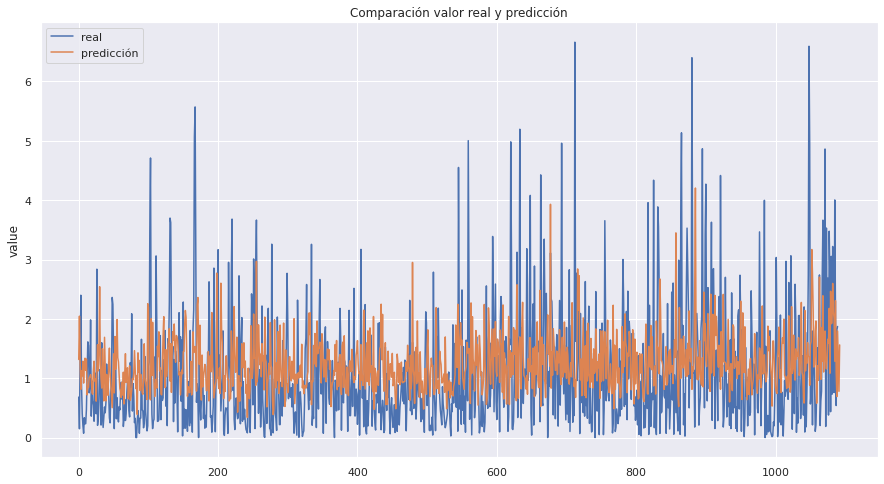

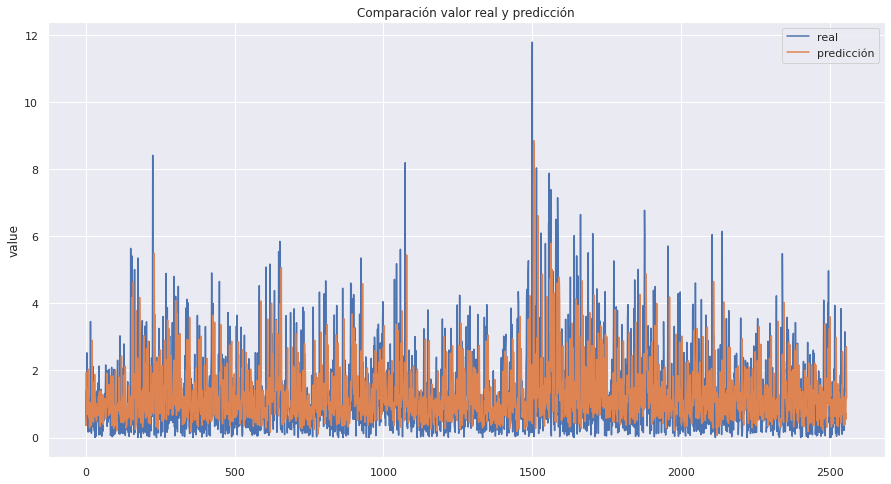

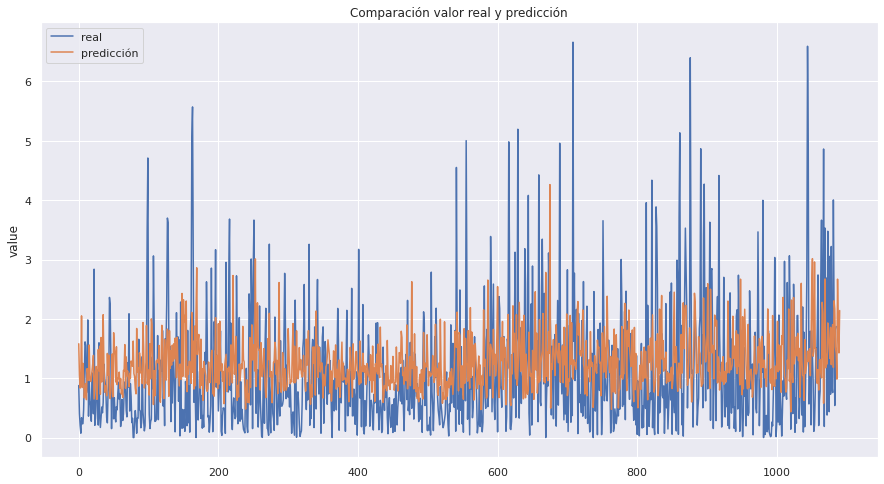

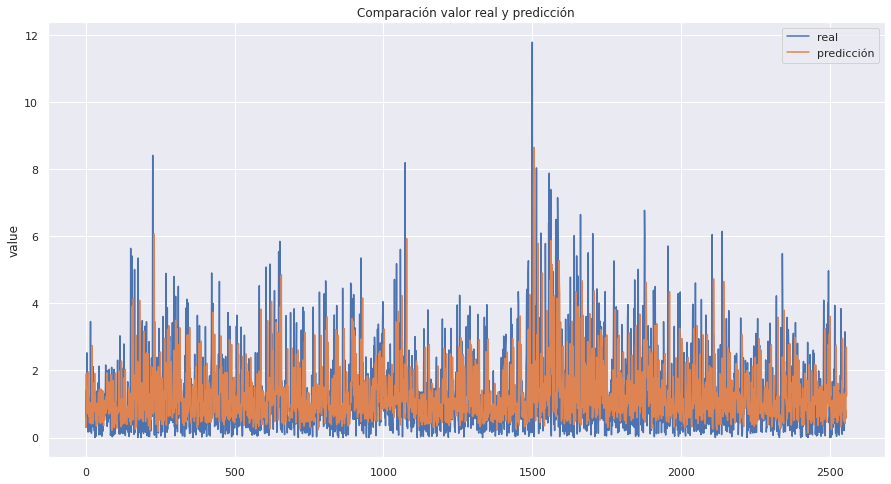

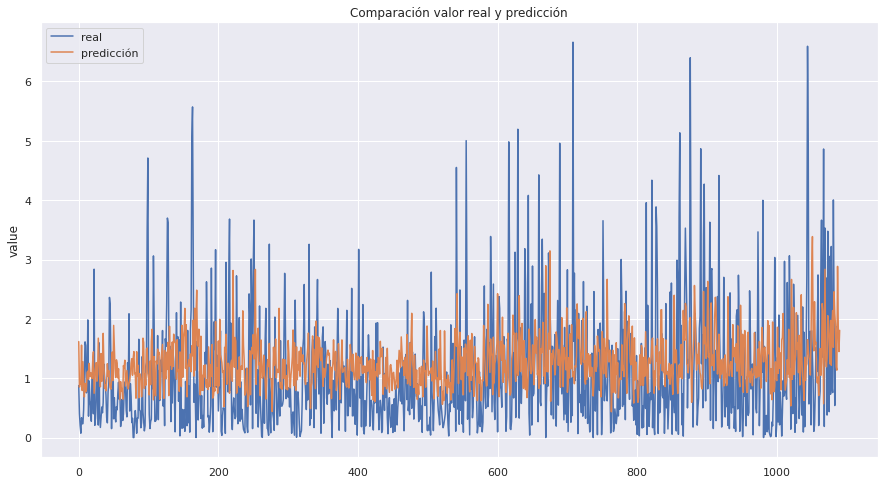

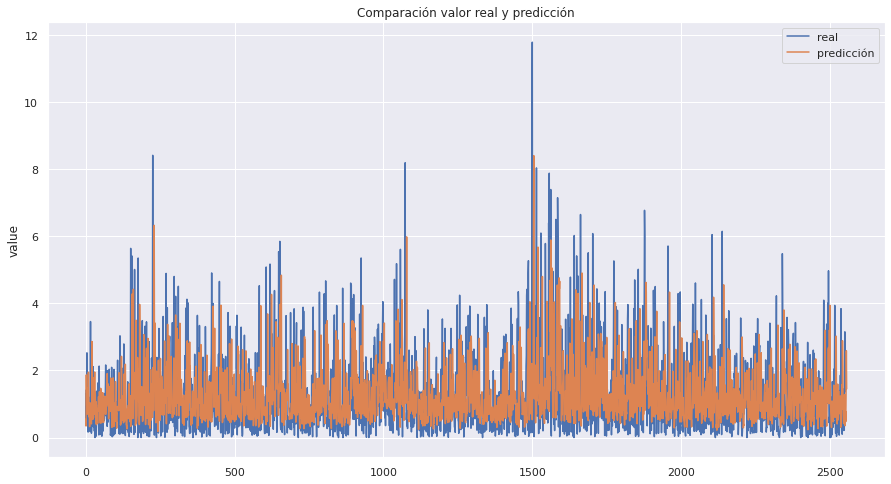

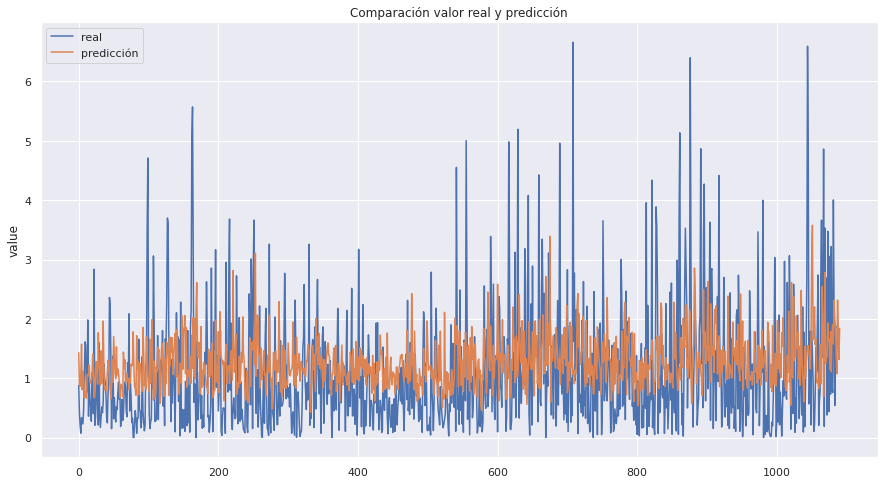

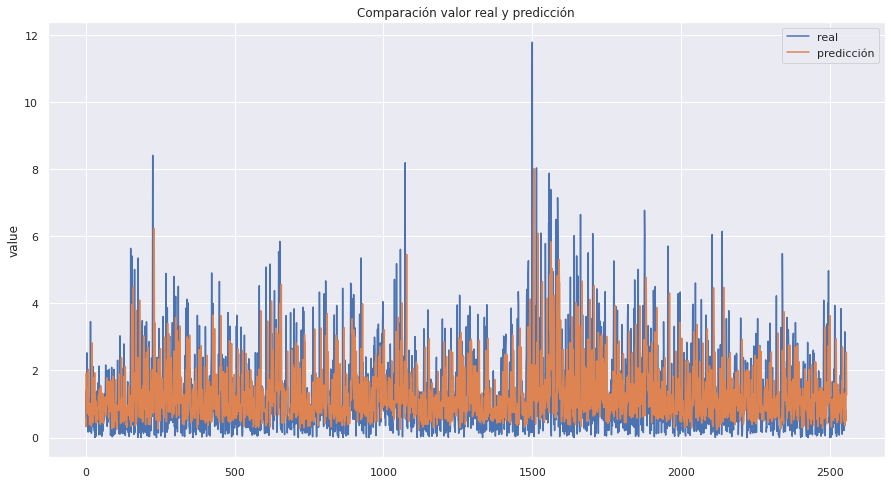

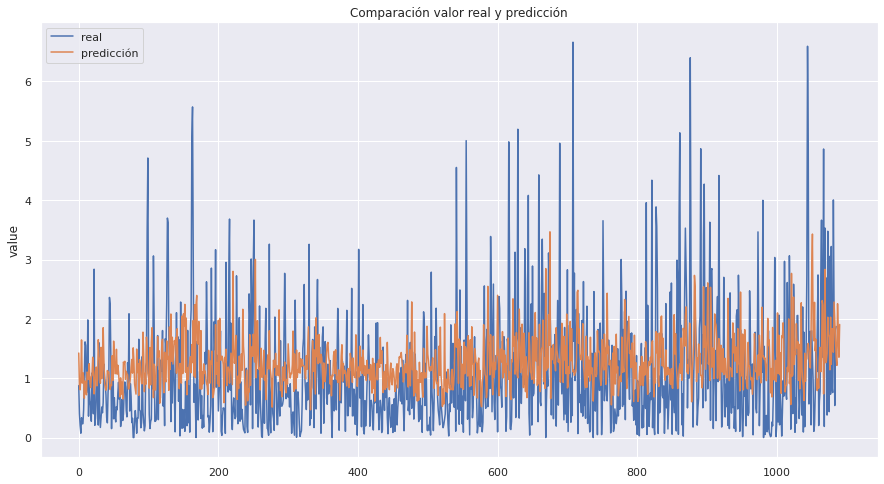

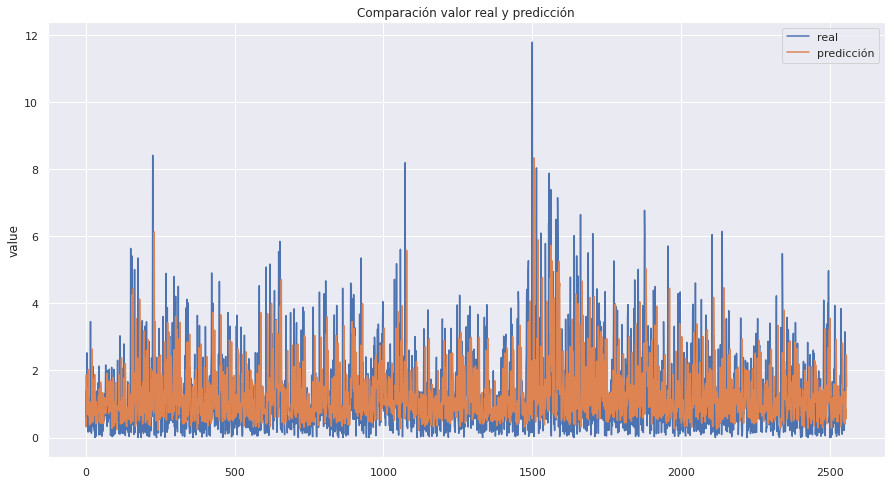

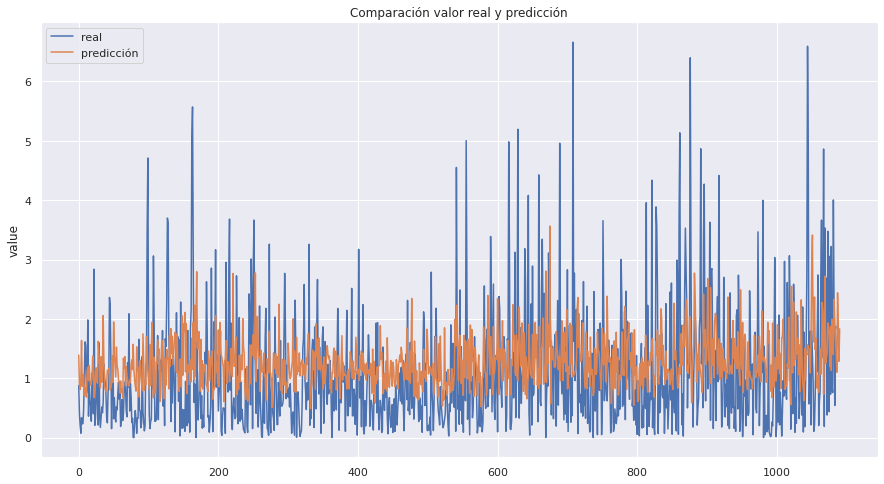

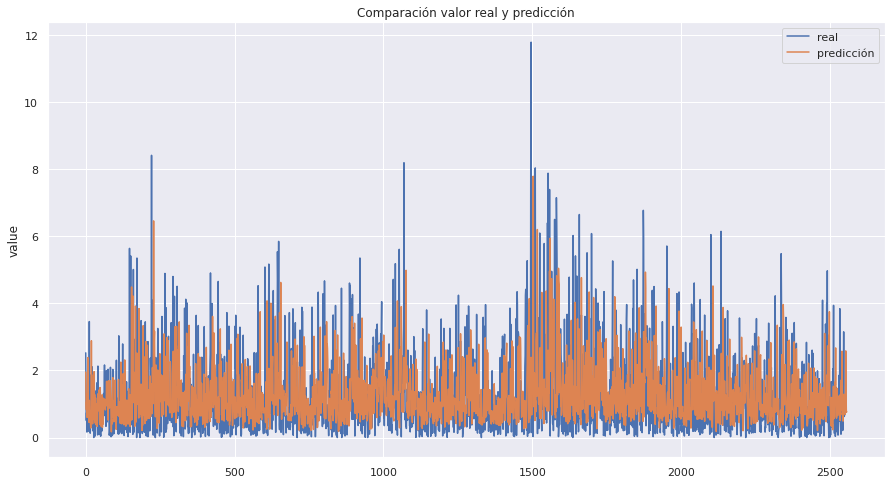

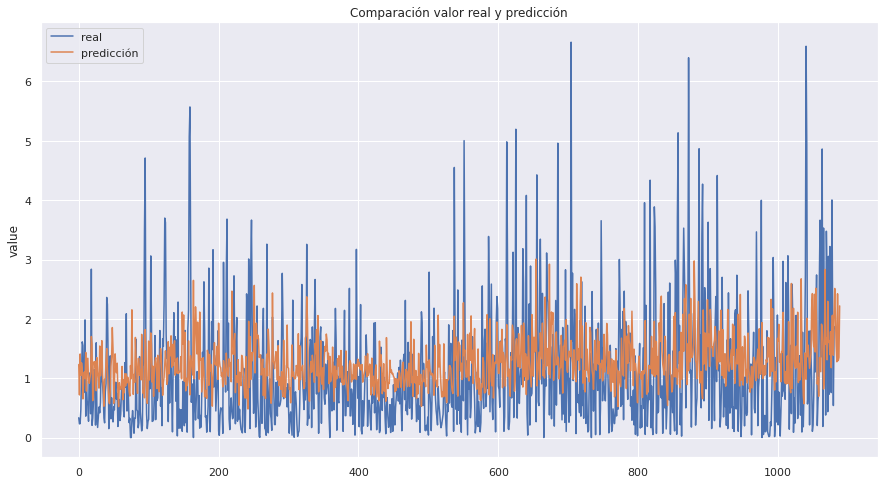

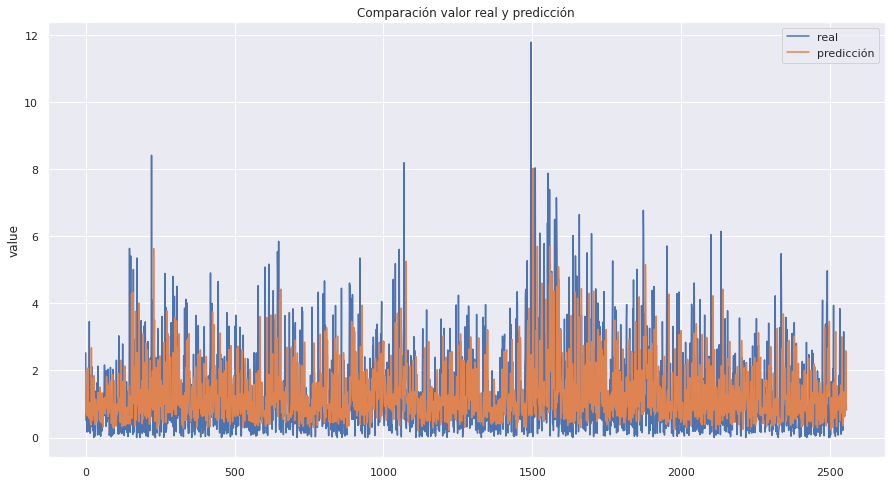

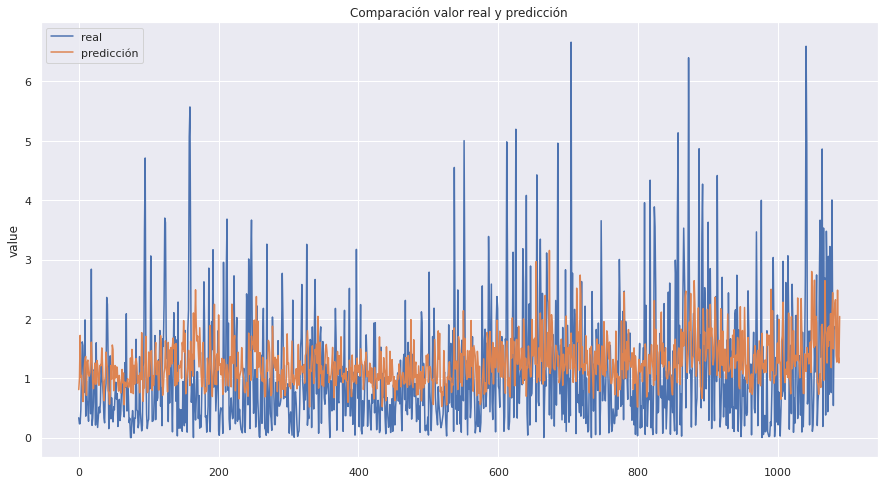

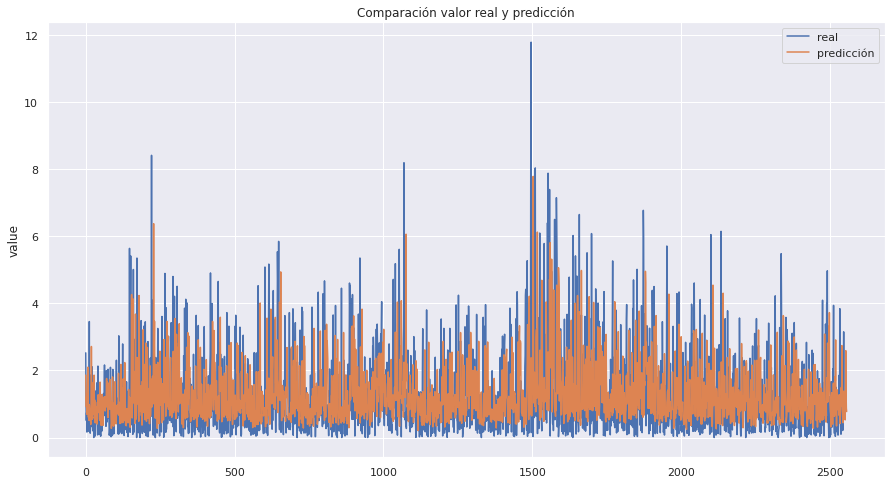

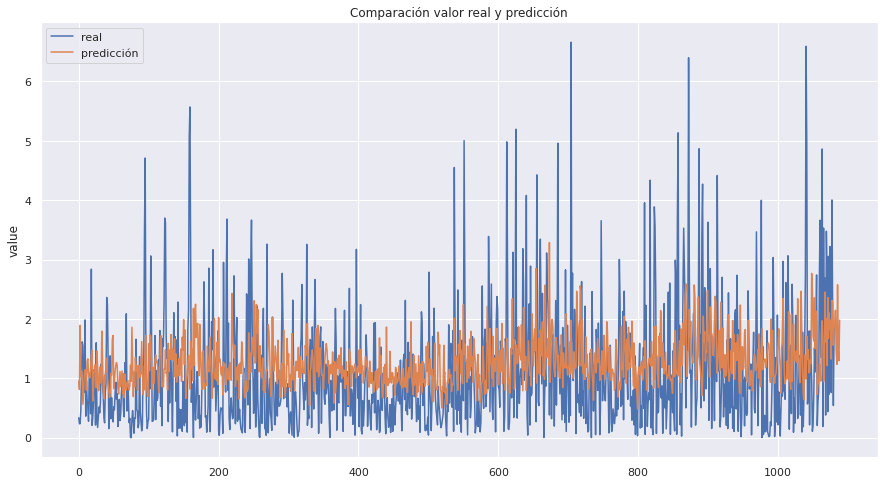

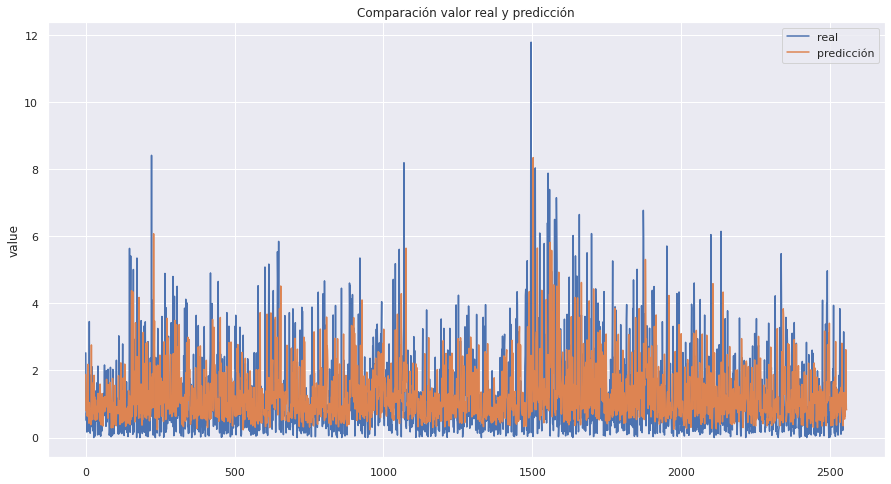

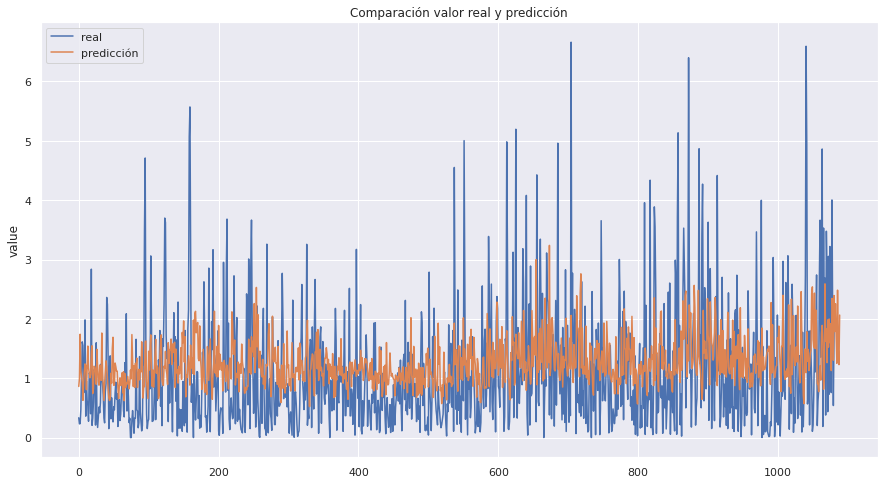

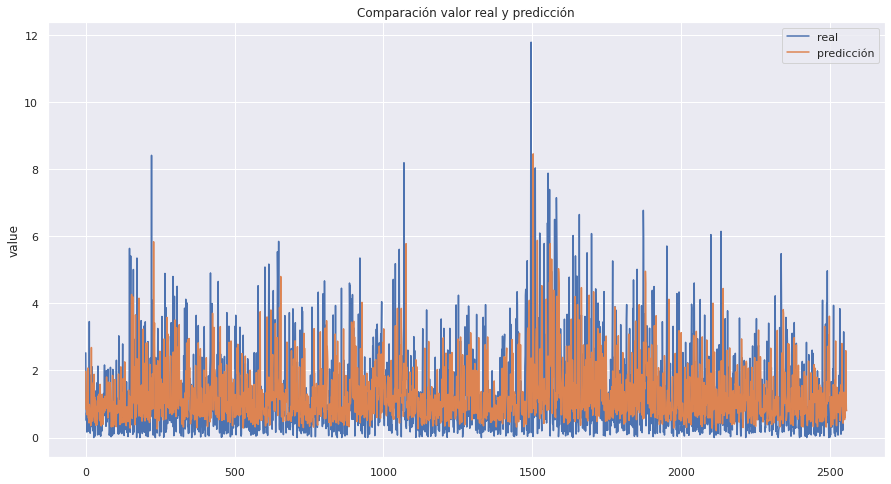

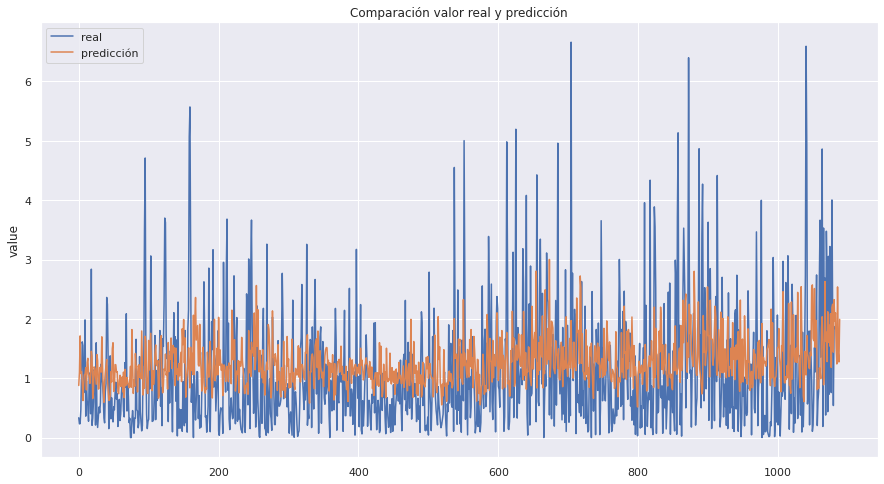

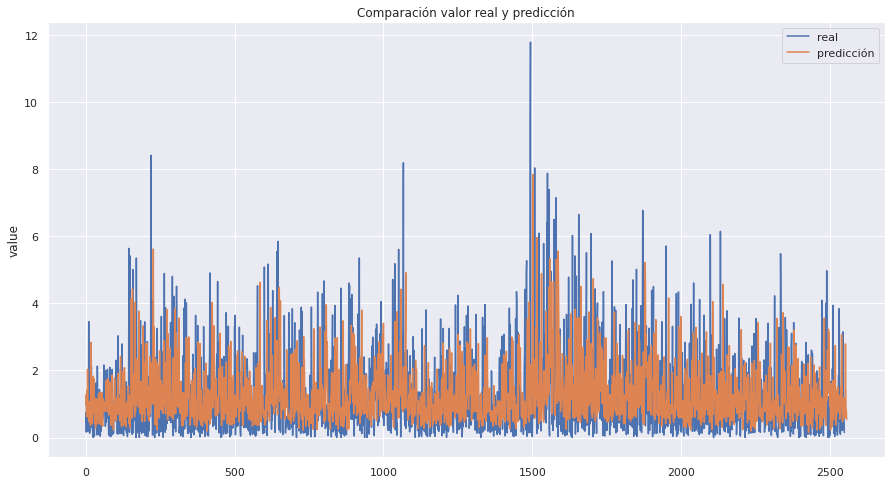

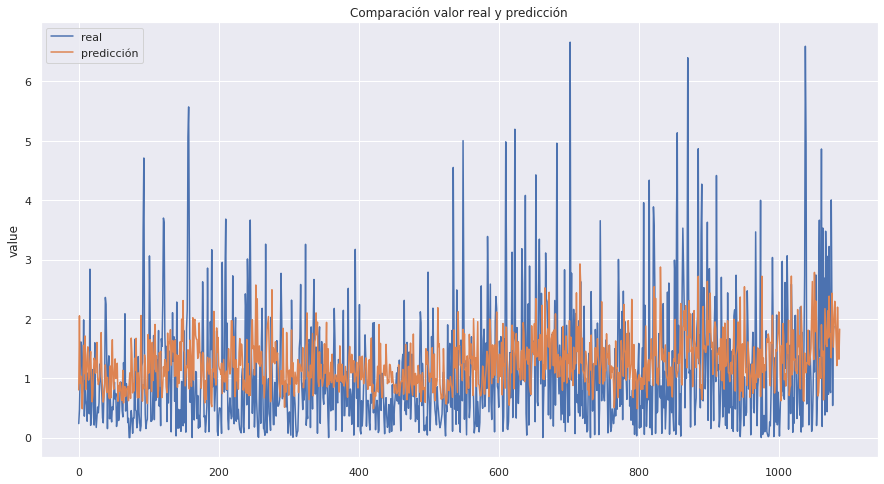

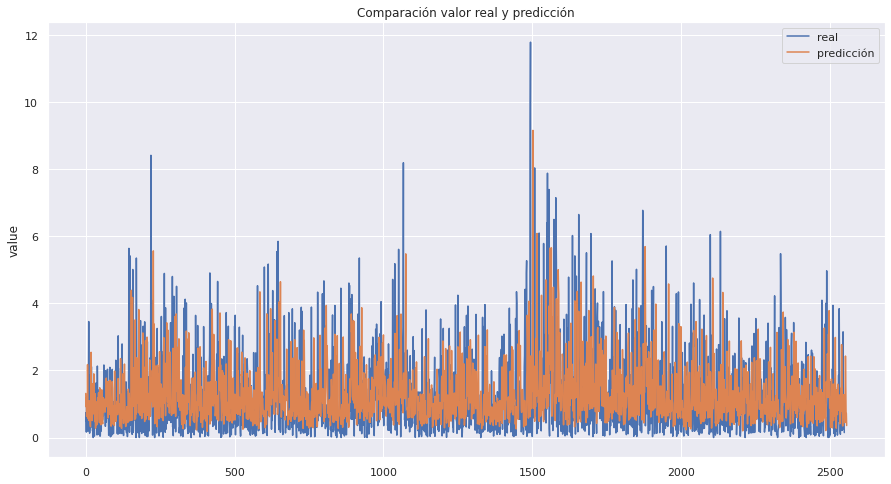

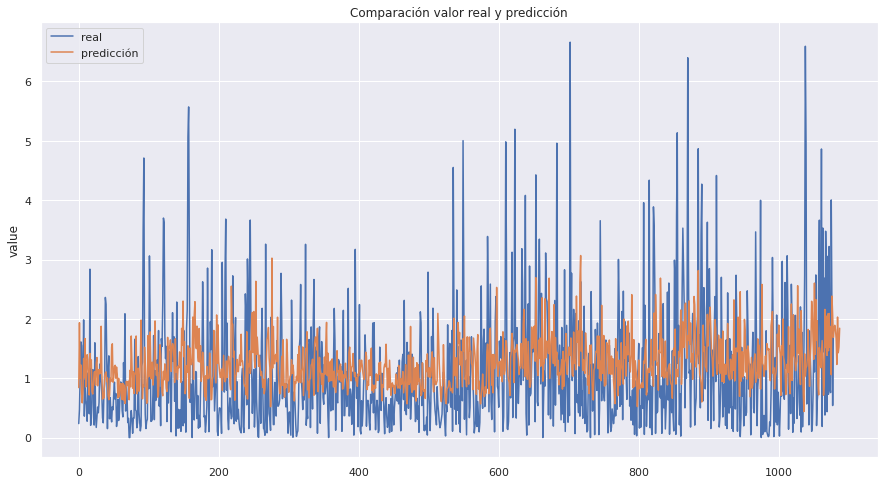

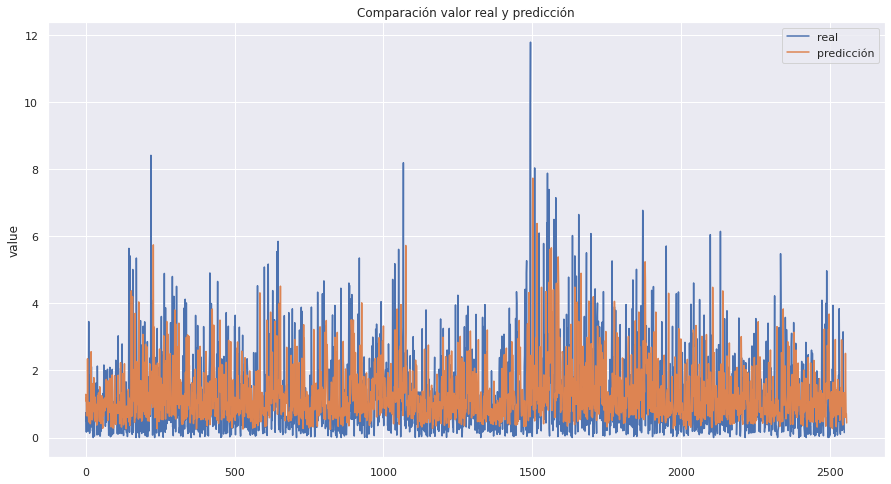

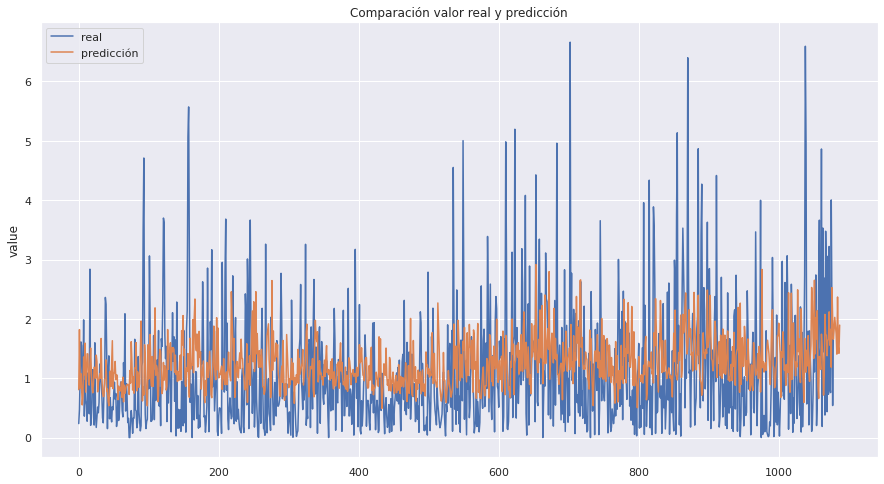

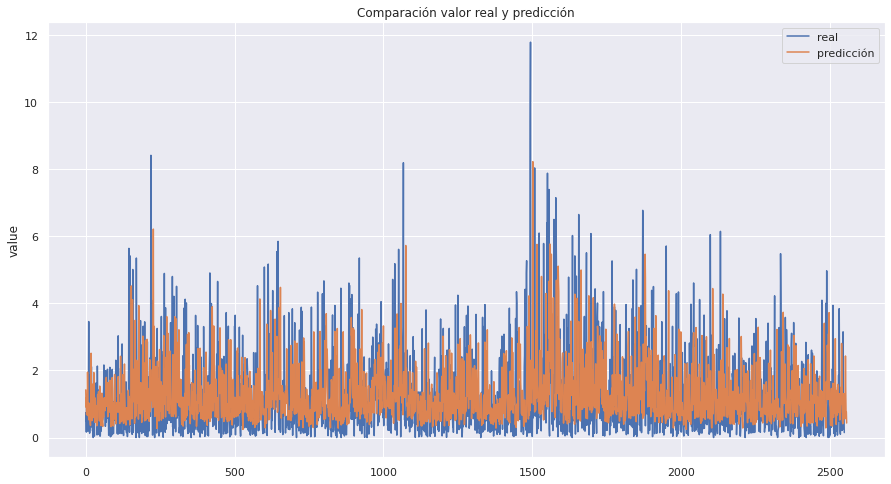

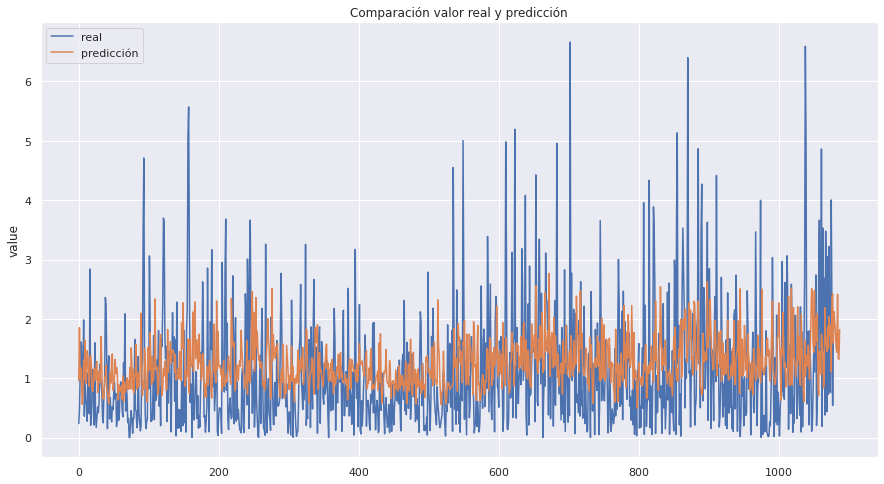

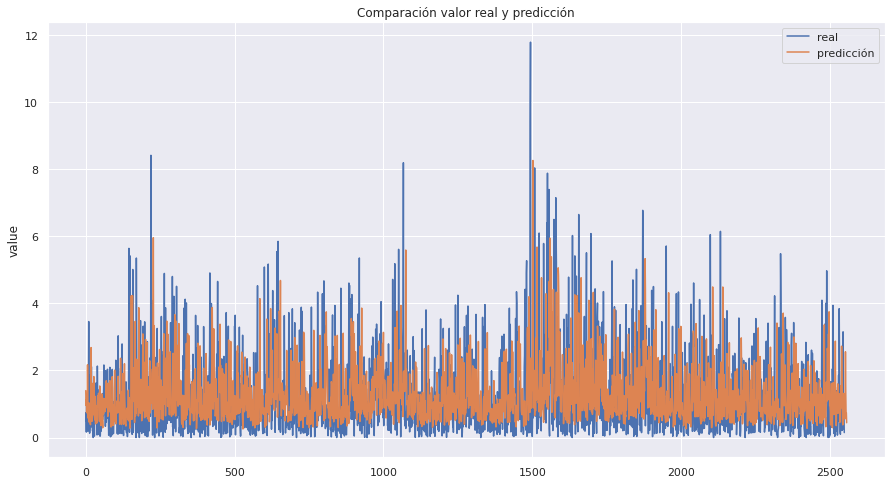

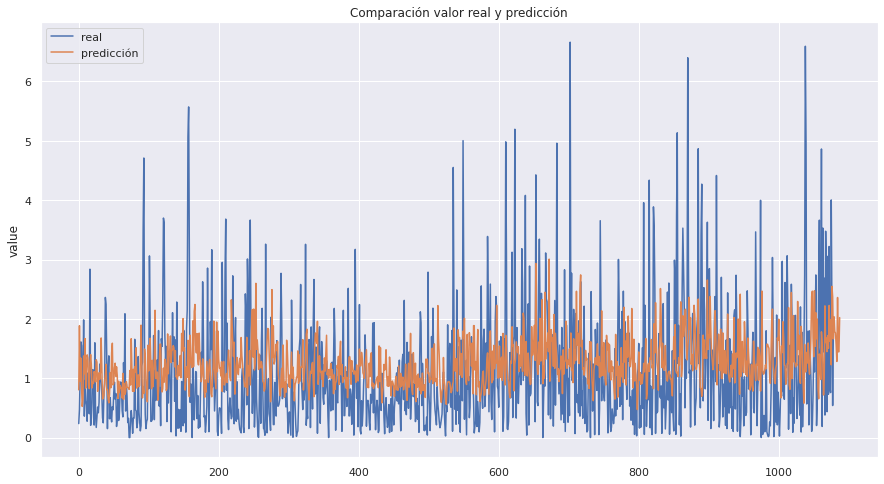

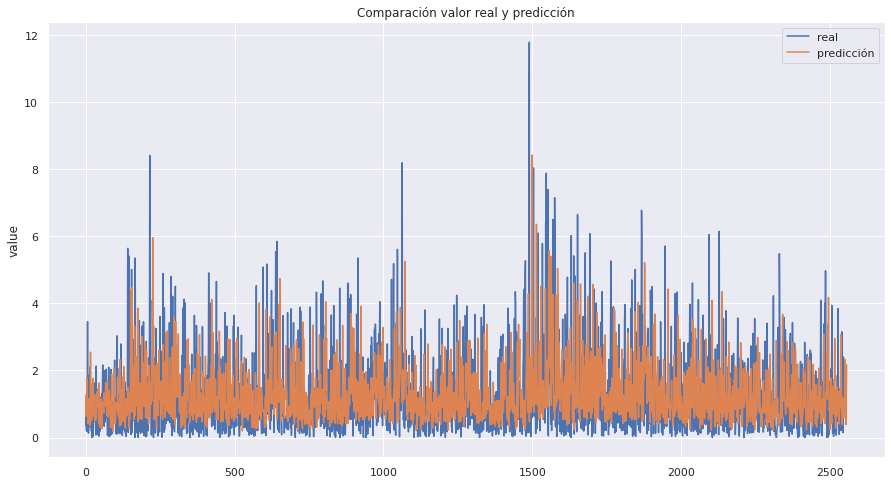

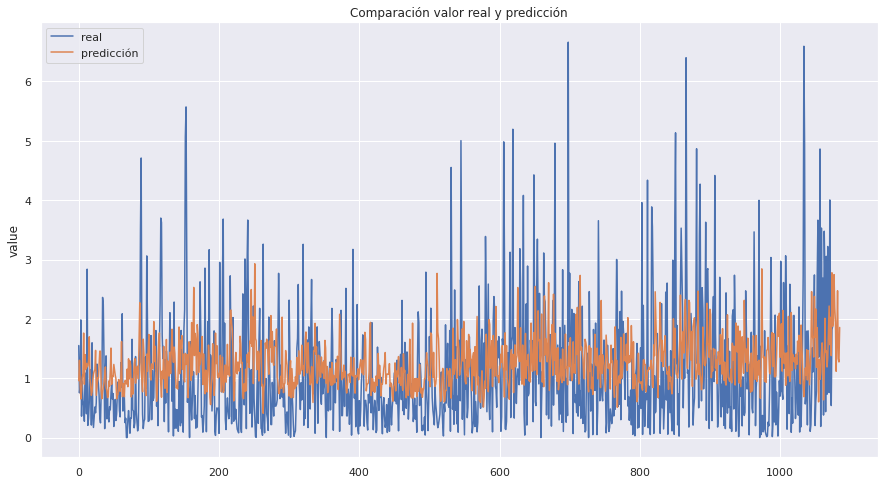

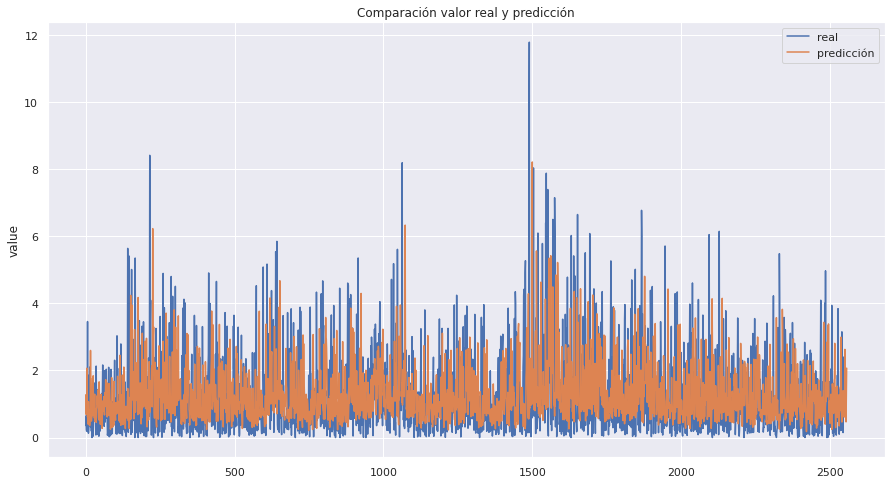

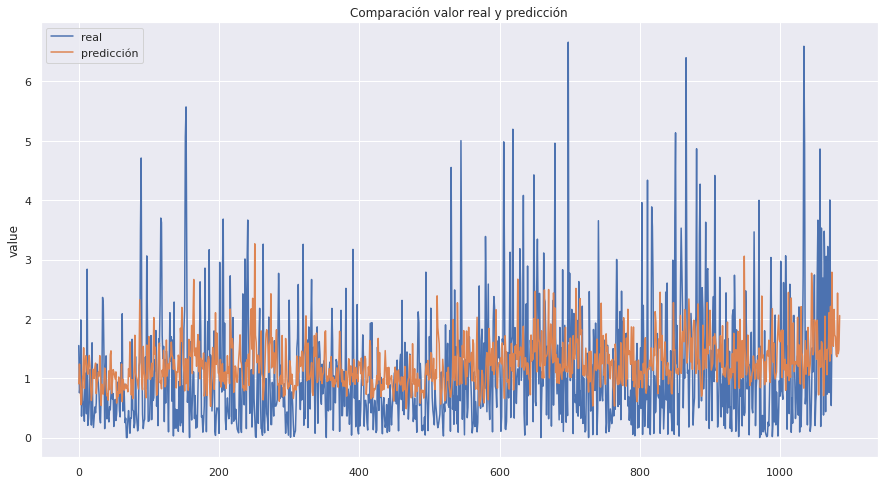

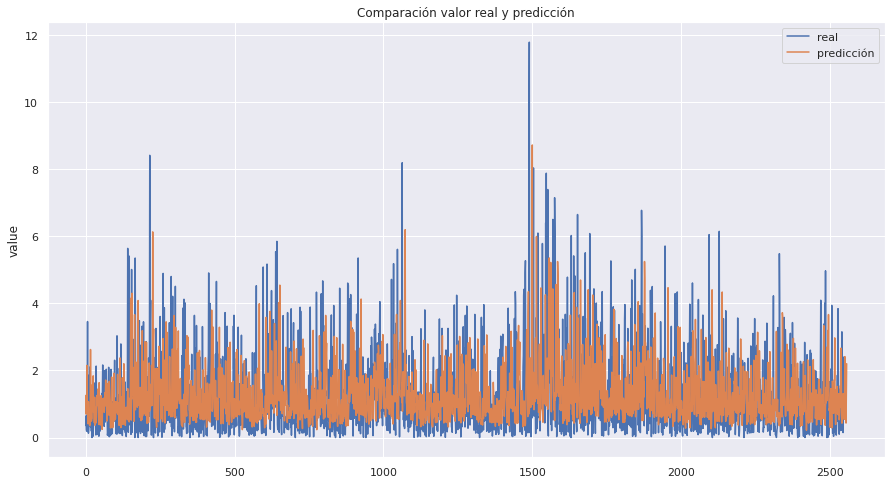

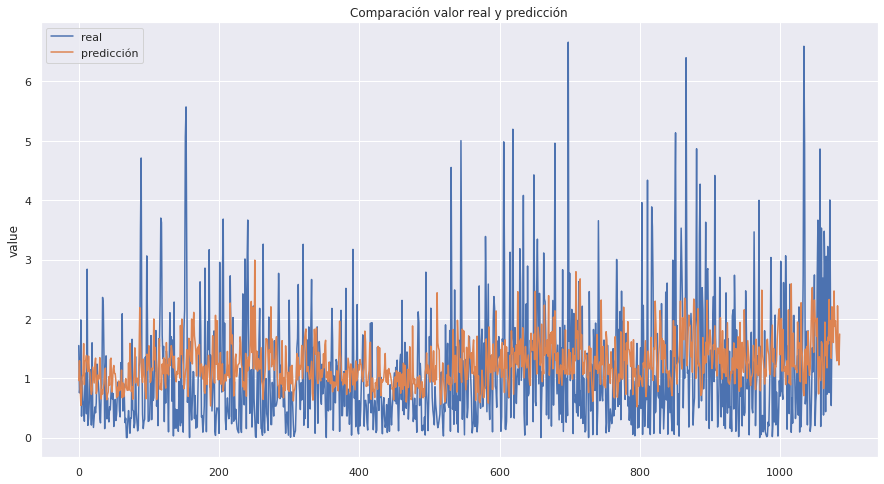

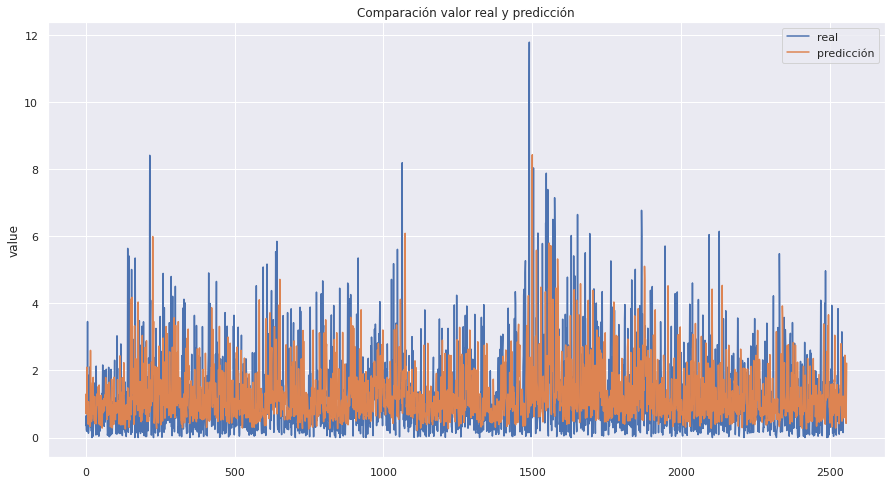

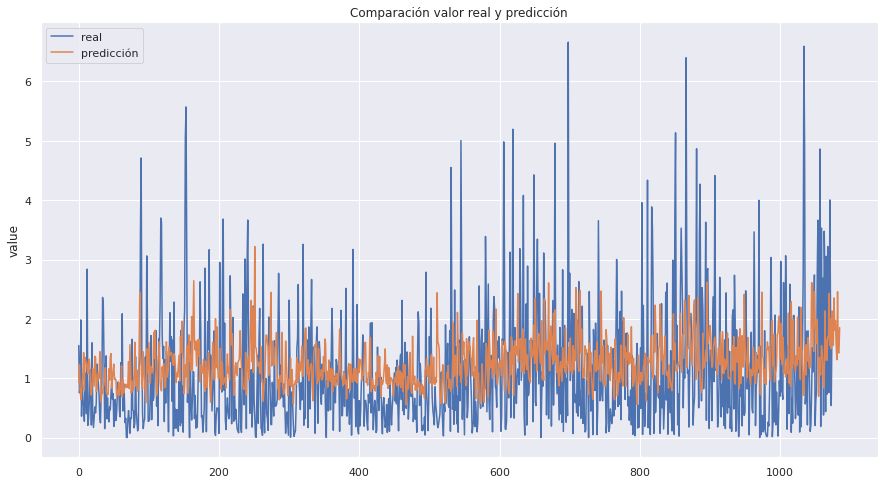

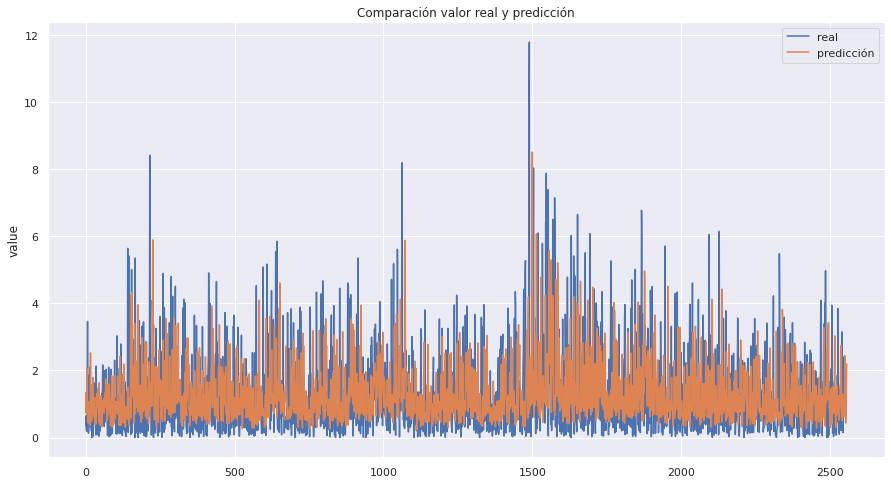

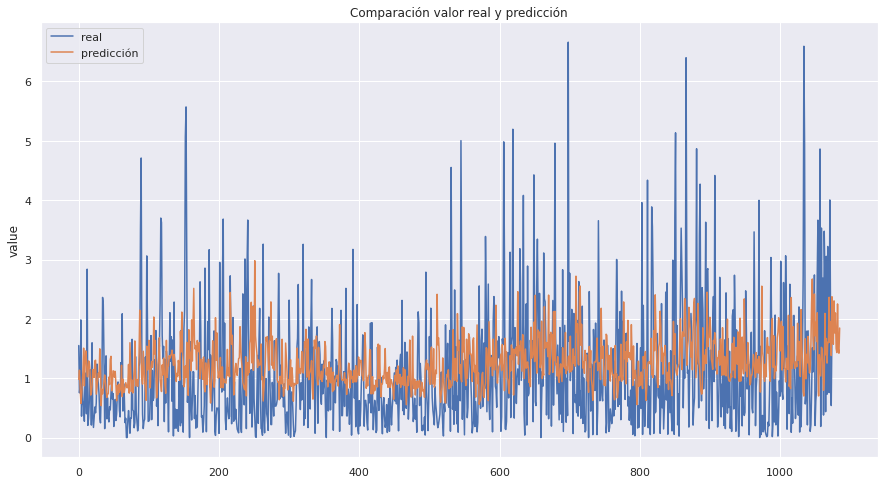

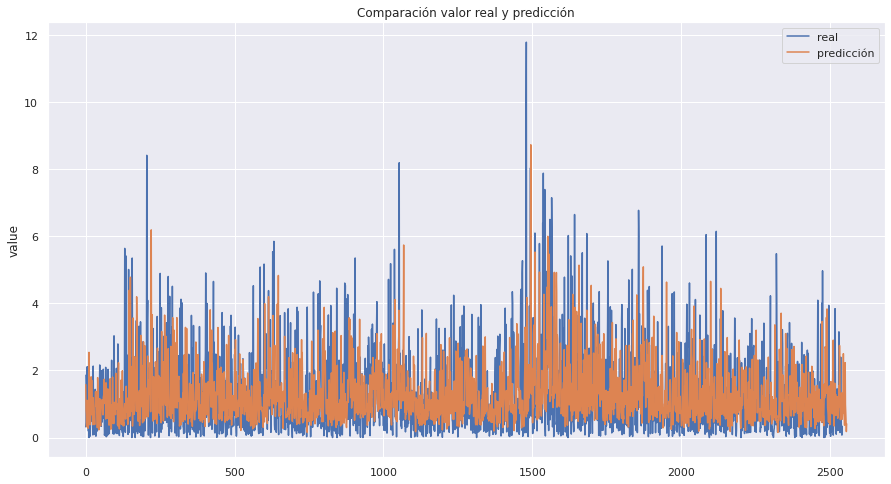

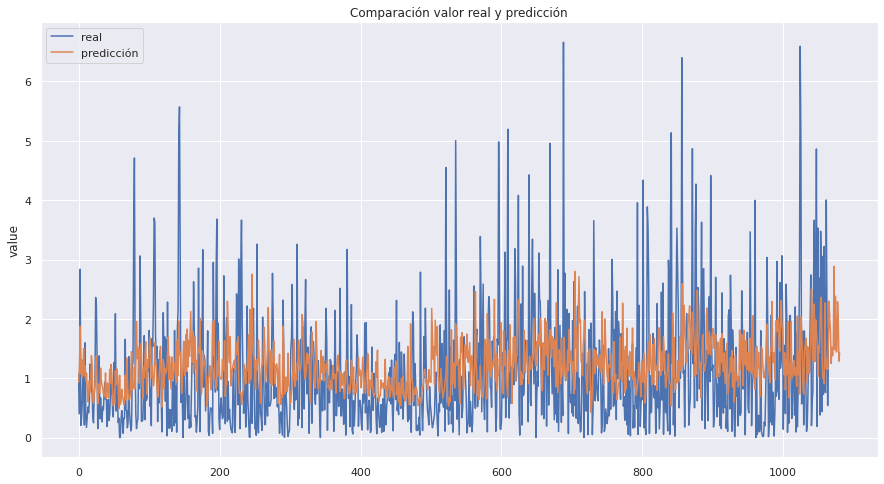

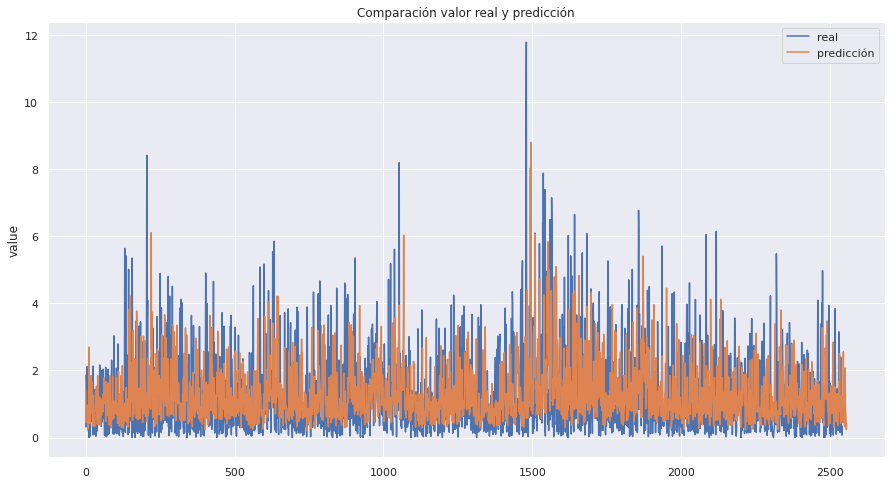

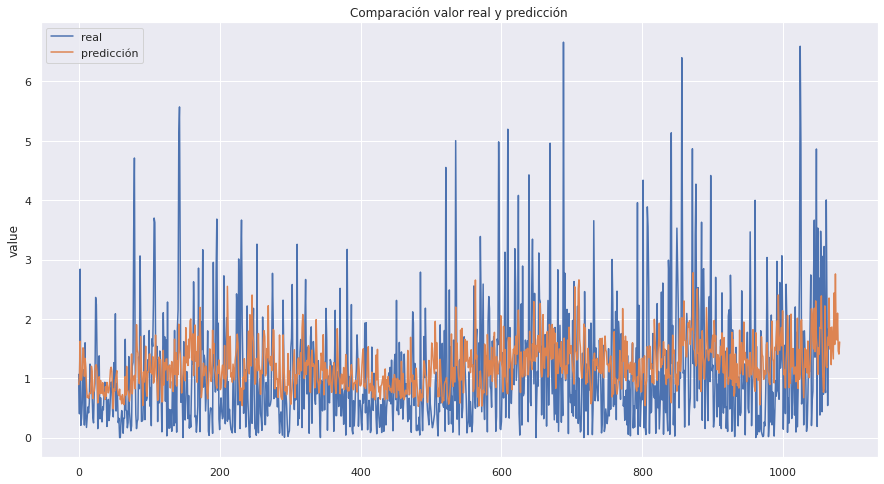

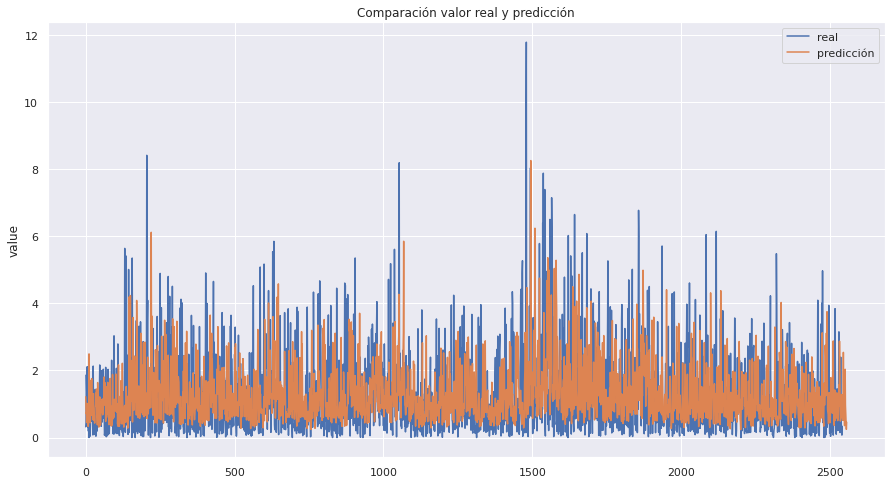

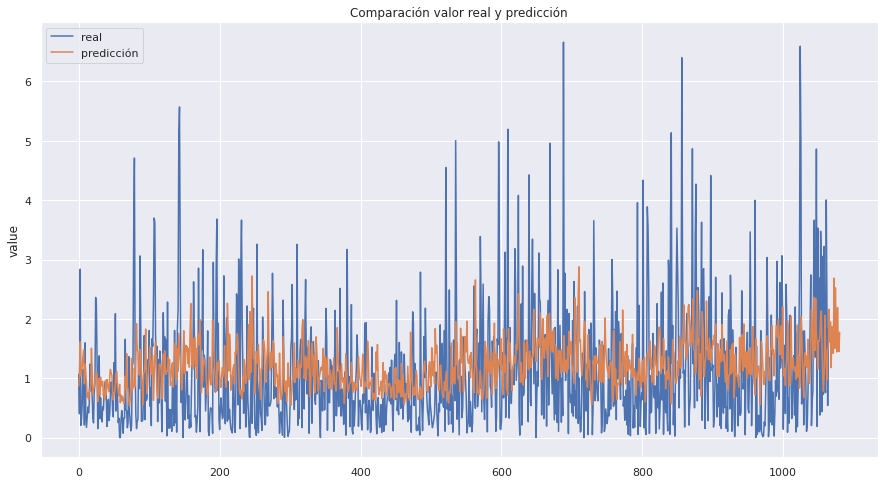

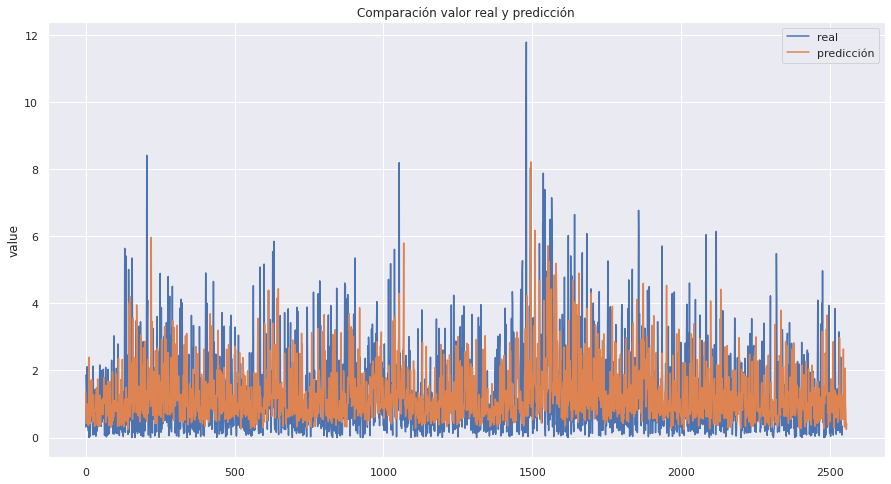

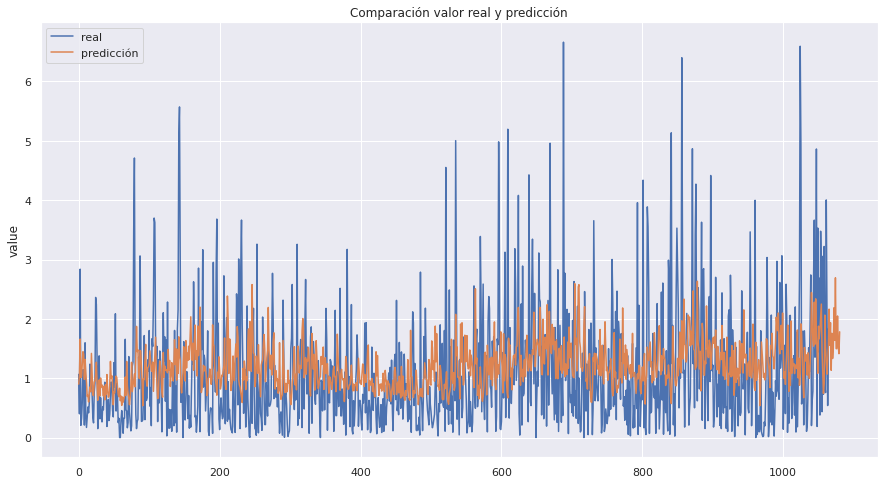

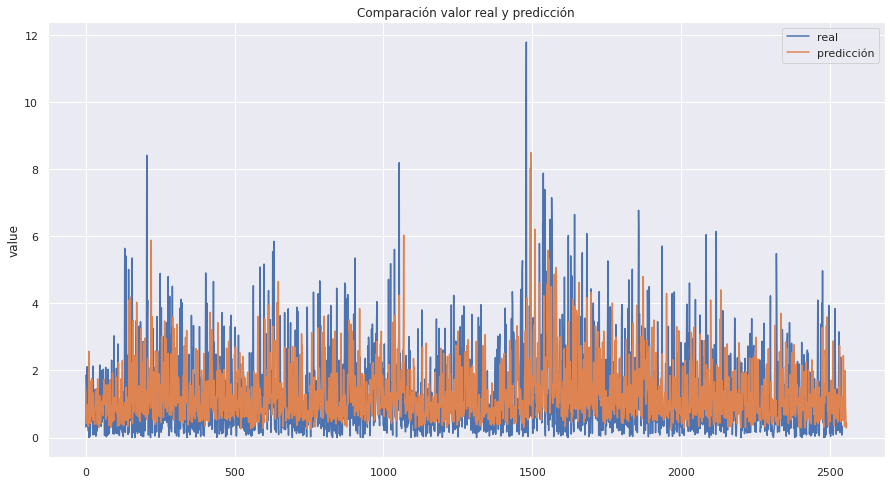

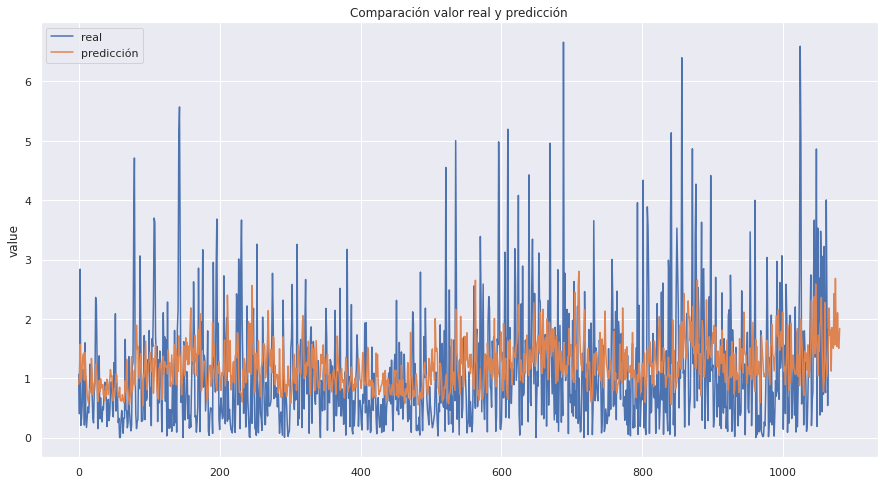

In [11]:
lags=[3,5,7,8,10,15]
n_estimators=n_estimators=[50,100,200,300,500]
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)